## ViT-L32

In [ ]:
!pip install transformers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 60.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 121.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 48.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.4 MB/s eta 0:00:

In [ ]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import transformers
import datasets
from transformers import AutoModel, AutoTokenizer
from datasets import load_dataset, load_metric
from torchvision.io import read_image
from torchvision.models import efficientnet_v2_l,EfficientNet_V2_L_Weights
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import copy
import matplotlib.pyplot as plt

In [ ]:
#data:
batch_size = 16
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=net.weights.transforms())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=net.weights.transforms())
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
DEVICD=torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')
class vitl32M(nn.Module):
    def __init__(self):
        super().__init__()
        #Initialize model
        self.weights = ViT_L_32_Weights.DEFAULT
        self.m=vit_l_32(weights=self.weights)
        self.ind_conv=self.m.conv_proj
        self.feture_ext=self.m.encoder
        self.aveg_p=nn.AdaptiveAvgPool2d(output_size=1)
        self.linoutput=nn.Linear(in_features=1024,out_features=10)
        self._preprocess = self.weights.transforms()
        # self.init_grad()

    def init_grad(self):
        for name, child in self.feture_ext.named_children():
            for param in child.parameters():
                param.requires_grad = False

        for param in m.encoder.layers.encoder_layer_23:
            param.requires_grad = True


    def preprocess_f(self,x):
        batch = self._preprocess(x).unsqueeze(0)
        return batch

    def forward(self, x):
        x = self.m._process_input(x)
        n = x.shape[0]
        batch_class_token = self.m.class_token.expand(n, -1, -1)
        x = torch.cat([batch_class_token, x], dim=1)

        x = self.feture_ext(x)
        x = x[:, 0]

        out_put=self.linoutput(x)
        return out_put

    def predict_2(self,img_path):
        img = read_image(img_path)

        batch = self._preprocess(img).unsqueeze(0)
        #print("111111111111111111  ",batch.shape)
        batch=batch.to(DEVICD)
        x = self.m._process_input(batch)
        n = x.shape[0]

        batch_class_token = self.m.class_token.expand(n, -1, -1)
        x = torch.cat([batch_class_token, x], dim=1)

        prediction = self.feture_ext(x)
        prediction = prediction[:, 0]

        return prediction

In [ ]:
net = vitl32M().to(DEVICD)

Downloading: "https://download.pytorch.org/models/vit_l_32-c7638314.pth" to /root/.cache/torch/hub/checkpoints/vit_l_32-c7638314.pth
100%|██████████| 1.14G/1.14G [01:08<00:00, 17.8MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
loss_list=[]
val_loss=[]
val_acc=[]
iteraton_count=100
traindata_count=3000
valdata_count=100

for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels=inputs.to(DEVICD), labels.to(DEVICD)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % iteraton_count == 99:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / iteraton_count:.3f}')
            loss_list.append(copy.deepcopy(running_loss/iteraton_count))
            running_loss = 0.0
        if i>traindata_count:
            break


    with torch.no_grad():
        val_avg_loss=0
        total_correct = 0
        total_instances = 0
        for i, data in enumerate(testloader, 0):
            inputs, labels = data
            inputs, labels=inputs.to(DEVICD), labels.to(DEVICD)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_avg_loss+=loss.item()

            classifications = torch.argmax(outputs, dim=1)
            #  comparing indicies of maximum values and labels
            correct_predictions = sum(classifications==labels).item()
            total_correct+=correct_predictions
            total_instances+=len(inputs)
            if i % iteraton_count == 99:
                val_loss.append(copy.deepcopy(val_avg_loss/iteraton_count))
                val_avg_loss=0.0
                val_acc.append(copy.deepcopy(total_correct/total_instances))
                total_correct = 0
                total_instances = 0

            if i>valdata_count:
                break


[1,   100] loss: 0.994
[1,   200] loss: 0.302
[1,   300] loss: 0.233
[1,   400] loss: 0.246
[1,   500] loss: 0.201
[1,   600] loss: 0.189
[1,   700] loss: 0.209
[1,   800] loss: 0.176
[1,   900] loss: 0.171
[1,  1000] loss: 0.151
[1,  1100] loss: 0.167
[1,  1200] loss: 0.204
[1,  1300] loss: 0.209
[1,  1400] loss: 0.185
[1,  1500] loss: 0.161
[1,  1600] loss: 0.166
[1,  1700] loss: 0.172
[1,  1800] loss: 0.164
[1,  1900] loss: 0.139
[1,  2000] loss: 0.140
[1,  2100] loss: 0.114
[1,  2200] loss: 0.120
[1,  2300] loss: 0.113
[1,  2400] loss: 0.190
[1,  2500] loss: 0.148
[1,  2600] loss: 0.127
[1,  2700] loss: 0.122
[1,  2800] loss: 0.109
[1,  2900] loss: 0.105
[1,  3000] loss: 0.100
[2,   100] loss: 0.068
[2,   200] loss: 0.065
[2,   300] loss: 0.074
[2,   400] loss: 0.072
[2,   500] loss: 0.063
[2,   600] loss: 0.077
[2,   700] loss: 0.076
[2,   800] loss: 0.094
[2,   900] loss: 0.112
[2,  1000] loss: 0.140
[2,  1100] loss: 0.084
[2,  1200] loss: 0.066
[2,  1300] loss: 0.079
[2,  1400] 

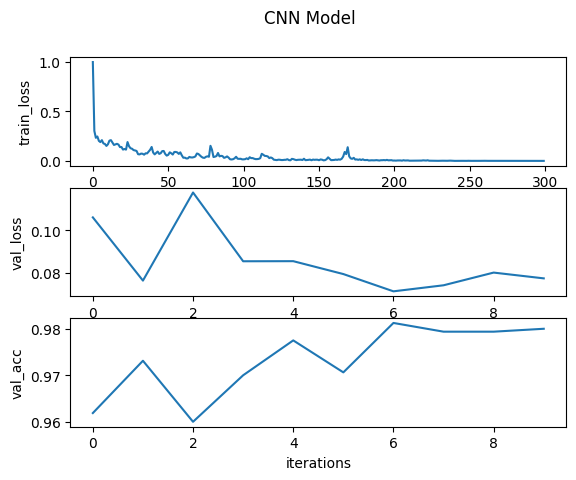

<Figure size 640x480 with 0 Axes>

In [ ]:
#results:
fig, axs = plt.subplots(3)
fig.suptitle('CNN Model')
axs[0].plot(loss_list)
axs[0].set_xlabel('iterations')
axs[0].set_ylabel('train_loss')

axs[1].plot(val_loss)
axs[1].set_xlabel('iterations')
axs[1].set_ylabel('val_loss')

axs[2].plot(val_acc)
axs[2].set_xlabel('iterations')
axs[2].set_ylabel('val_acc')
plt.show()
plt.savefig("vit_models_loss_plot.png")